<a href="https://colab.research.google.com/github/jacquelinedoan/seq_test/blob/main/sequential_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reinforcement Learning for Optimal Alpha Spending Function in Sequential Hypothesis Testing**
Rambling by Jacqueline.

## Introduction
Product experiements are commonly in the form of a $z$-test (or $t$-test), comparing the 2 means of some KPI of both the control and test groups, say $\mu_1$ and $\mu_2$ respectively. The test is of course conducted after all data is collected. Furthermore,
$$H_0: \mu_1 = \mu_2$$
$$H_A: \mu_1 < \mu_2$$

Given significance level $\alpha$, if we find statistical significance, $H_0$ is rejected and we accept $H_A$; the new product is considered a success.
*However, what happens when we do not find significance?*

Say that we decided more data is needed and the data collection period is extended. Both the control and test groups grow in sample size. We then conduct the $z$-test a second time at some significance level. *Why don't we continue this process until we reached significance?*

### *Sampling to reach a foregone conclusion*
**Type I Error** (False Positive Error) is the risk of incorrectly rejecting a true $H_0$. In other words, we conclude the new version of the product is a success while it is not, risking shipping a product that does not have a positive effect on our customers.

**Significance level $\alpha$** is also the maximum probability of observing Type I Errors that the experimenter will accept in the long run.

If we conduct the test once, the probability of not getting a FP error is $1-\alpha$. If we conduct the tests above $k$ times, each at $\alpha$, the change of observing at least one false positive grows
$$P(\geq 1 \text{ FP }) = 1 - P(< 1 \text{ FP }) = 1 - (1-\alpha)^k$$

*As $k \to ∞$, just by chance, the probability you make at least one FP increases.*



### Sampling to reach a foregone conclusion, but formal.
Let $X_1, X_2, \dots \sim N(\mu, \sigma^2)$ where $\sigma^2$ is known. Consider the test of $H_0: \mu=0$ and $H_A: \mu\neq 0$. Let $S_n = \sum_{i=1}^nX_i$. Under $H_0$, $S_n \sim N(0, n\sigma^2)$. Thus the rejection region is such that $|S_n|>1.96\sigma\sqrt{n}$ for $\alpha=0.05$. We will show that as $n\to ∞$, or, as we keep doing more iterim tests, we will eventually (in probability) arrive at the rejection region. *The Law of Iterated Logarithm* implies that

$$
\lim_{n\to ∞} \sup \frac{S_n}{\sigma\sqrt{2n\log \log n}}=1 \quad \text{ with probability } 1
$$

In other words, $S_n$ is growing as fast as the denominator, which is unbounded.

### Lan & DeMets (1983)
Recall the typical 2 sample problem, where we want to compare the responses to treatments A and B, say the responses follows the distributions $N(\mu_A, \sigma)$ and $N(\mu_B, \sigma)$ respectively, and $H_0: \mu_A = \mu_B$. Say there are $n$ observations in each group ($2n$ observations in total), and a $z$-test is conducted. Then we reject $H_0$ if and only if

$$Z=\left|\frac{\bar{X}_A - \bar{X}_B }{\sqrt{2\sigma^2/n}}\right|>1.96$$

Now, say we collect data such that once $n$ new observations are collected in each group, we conduct another $z$-test, only on the new data for the sake of independence. We will conduct $K$ tests in total, and there will be $2nK$ observations at the end. The statistic at step $j$ is

$$
Y_j = \frac{\bar{X}_{A_j} - \bar{X}_{A_j}}{\sqrt{2\sigma^2/n}} \sim N(\delta^*, 1)
$$

where $\delta^* = \frac{\delta}{\sqrt{2\sigma^2/n}}$. Then $S_k = \sum_j^kY_j \sim N(\sigma^*k, k)$. Then the rejection region per interim test is defined by boundaries $b_k$, namely

$$|
S_k|>b_k
$$

such that

$$
P(|S_1|\leq b_1, \dots, |S_K|\leq b_K) \leq 1-\alpha
$$

Equivalently, let $f$ be the joint pdf of the score statistics,

$$
\int^{b_1}_{-b_1} \dots \int^{b_K}_{-b_K} f(s_1, \dots, s_K)d_{s_1}\dots d_{s_K} = 1-\alpha
$$

Lan & DeMets (1983) proposed the $\alpha$-spending function, $\alpha^*$, a non-decreasing function. The significance level to use at each step is $\alpha_k = \alpha^*(t_k) - \alpha^*(t_{k-1})$. They went further to suggest a functional form, namely

$$
\alpha^*(t) = \alpha \log (1+(e-1)t)
$$

for the set up in Pocock (1977).

### Introduction
Sequential tests are statistical tests to solve the problem above. Well-known techniques include group sequential tests, always valid inference, and corrected-alpha approach. Sequential testing does not required the use of RL -- the methodologies above are well-established and optimal.

However, I'm particularly interested in group sequential tests as a (Constrained) Markov Decision Process. Under this view, the optimal **$\alpha$ spending function** is the optimal policy. This is a function that spreads $\alpha$ over the sequence of $z$-tests, say $\alpha_1, \dots, \alpha_k$.

One can describe what I'm doing below as this picture:

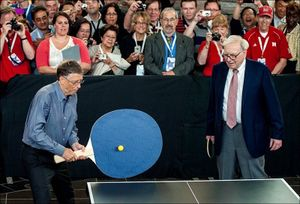



### Constrained Markov Decision Process (CMDP)
Consider a Decision Maker (DM) who is conducting a sequence of $K$ 2-sample t-tests (unknown variance) between control and test groups with
$$H_0: \mu_C=\mu_T $$
$$H_A: \mu_C < \mu_T$$
At each test $k$, the DM has 3 actions:
* Stop and Reject. If $H_A$ is true: $+R_{TP} = 1$
* Stop and Reject. If $H_0$ is true: $-R_{FP} = -1$
* Continue Sampling: $-c$ for sampling cost

At the terminal state $K$, the DM stops and accepts.

---


In [48]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

In [49]:
# Class to simulate the sequential tests
class SequentialTEnv:
    def __init__(self,
                 mu0=0.0,
                 mu1=0.5,
                 sigma=1.0,
                 alpha=0.05,
                 max_looks=50,
                 batch_size=10,
                 mc_precompute_n=5000,
                 seed=None):
        self.mu0 = mu0 # control group
        self.mu1 = mu1 # test group
        self.sigma = sigma
        self.alpha = alpha
        self.max_looks = max_looks
        self.batch_size = batch_size
        self.mc_precompute_n = mc_precompute_n
        self.rng = np.random.default_rng(seed)
        self.reset()

    def reset(self,
              hypothesis=None):
        # reseting for a new experiement
        if hypothesis is not None:
            self.hypothesis = hypothesis
        else:
            self.hypothesis = self.rng.choice([0, 1])
        self.n_seen = 0
        self.alpha_rem = self.alpha
        self.done = False
        self.history = []
        return self._get_state()

    def _sample_batch(self):
        # Simulate the batch of control and test subjects
        x_c = self.rng.normal(self.mu0,
                              self.sigma,
                              self.batch_size)
        mu = self.mu0 if self.hypothesis == 0 else self.mu1
        x_t = self.rng.normal(mu,
                              self.sigma,
                              self.batch_size)

        return x_c, x_t

    def _get_state(self):
        # % seen, out of max subjects
        frac_n = self.n_seen / (self.max_looks * self.batch_size)
        # % alpha remaining
        frac_alpha = self.alpha_rem / self.alpha
        return np.array([frac_n, frac_alpha], dtype=np.float32)

    def _ttest(self, x_c, x_t):
        # calculate the t statistic
        n1, n2 = len(x_c), len(x_t)
        mean1, mean2 = np.mean(x_c), np.mean(x_t)
        var1, var2 = np.var(x_c, ddof=1), np.var(x_t, ddof=1)
        # estimate variance
        se = np.sqrt(var1/n1 + var2/n2)
        t_stat = (mean1 - mean2) / se
        df_num = (var1/n1 + var2/n2)**2
        df_den = (var1**2 / ((n1**2)*(n1-1))) + (var2**2 / ((n2**2)*(n2-1)))
        df = df_num / df_den
        from scipy.stats import t
        p_val = 2 * (1 - t.cdf(abs(t_stat), df))
        return t_stat, p_val

    def step(self, action):
        # Action = fraction of remaining alpha to spend
        frac = np.clip(action, 0.0, 1.0)
        # spend alpha
        spend = frac * self.alpha_rem
        spend = min(spend, self.alpha_rem)
        self.alpha_rem -= spend

        # Draw new batch
        x_c, x_t = self._sample_batch()
        self.n_seen += self.batch_size

        # Pooled variance, Welch's t
        t_stat, p_val = self._ttest(x_c, x_t)

        reward, cost = 0.0, 0.0 # initialize
        if p_val < spend:
            self.done = True
            if self.hypothesis == 1:
                reward = 1.0  # true positive
            else:
                cost = 1.0    # false positive
        elif self.n_seen >= self.max_looks * self.batch_size or self.alpha_rem <= 1e-12:
            self.done = True

        return self._get_state(), reward, cost, self.done



Framing the problem as a CMDP, our goal is to maximize power (probability of correct rejection) while under the constraint that the False Positive Rate is bounded by $\alpha$.
$$ P(\text{ Reject } H_0 | H_0 \text{ true })\leq \alpha$$

The **objective function** is then,
$$J(\pi) = E_\pi(\text{Power}) \quad \text{ s.t. } \quad  E_\pi(\text{Type I Error}) \leq \alpha $$
The objective function is also optimized for power if we optimize for utility (reward). Equivalently,
$$J(\pi)= E_{H_A}(\text{Utility}) \quad \text{ s.t. } \quad E_{H_0}(1\{\text{Reject}\}) \leq \alpha $$

This is a contrained optimizatio problem, so we use **Lagrangian Multiplier** to formulate it into a saddle optimization problem:
$$L(\pi, \lambda) = J(\pi) - \lambda\times(E_{H_0}(\text{Reject}) - \alpha )$$
We optimize $L$ by  **Primal-Dual Alogrithm**, i.e., iteratively

1.   *Policy Update*: Maximize $J(\pi)$ via Proximal Policy Optimization (PPO)
2.   *Multiplier Update*: Minimize $- \lambda\times(E_{H_0}(\text{Reject}) - \alpha )$ via dual ascent algoritm for constraint

---

In [50]:
# PPO requires 2 NN, Actor (Policy Net) and Critic (Value Net)

# PolicyNet:
# Input: current state (_get_state output)
# Output: prob dist over possible actions (possible alpha fraction spend)


class PolicyNet(nn.Module):
    def __init__(self, state_dim=2, hidden=32):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.mu = nn.Linear(hidden, 1)
        self.log_std = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = torch.sigmoid(self.mu(h))  # action in [0,1]
        std = torch.exp(self.log_std)
        return mu, std # of action distribution

    def sample(self, x):
      # sample action
        mu, std = self(x)
        dist = torch.distributions.Normal(mu, std)
        action = torch.clamp(dist.sample(), 0.0, 1.0)
        log_prob = dist.log_prob(action)
        return action, log_prob

# ValueNet:
# Input: current state
# Output: expected cumulative reward

class ValueNet(nn.Module):
    def __init__(self, state_dim=2, hidden=32):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.v = nn.Linear(hidden, 1)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.v(h)

In [51]:
# Primal-dual update

def run_training(config):
    # Initialization
    env = SequentialTEnv(alpha=config['alpha'],
                        max_looks=config['max_looks'],
                        batch_size=config['batch_size'])

    policy = PolicyNet()
    value = ValueNet()
    opt_pi = optim.Adam(policy.parameters(), lr=config['lr'])
    opt_v = optim.Adam(value.parameters(), lr=config['lr'])

    lambda_dual = torch.tensor(1.0, requires_grad=False)

    # Initialize list to store cumulative alpha history
    cumulative_alpha_history = []
    simulation_interval = 20 # Record history every 20 iterations

    # Training Loop
    for it in range(config['train_iters']):
        batch = []
        for ep in range(config['batch_episodes']):
            # Simulate under the null hypothesis to record alpha spending
            s = env.reset(hypothesis=0)
            done = False
            ep_reward, ep_cost = 0.0, 0.0
            log_probs, states, actions = [], [], []
            episode_cumulative_alpha = []
            cumulative_spent = 0.0

            while not done:
                st = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
                # Use the current policy to sample action
                a, logp = policy.sample(st)

                # Calculate alpha spent in this step
                # Need to temporarily update env's alpha_rem to calculate alpha_to_spend correctly for recording
                temp_alpha_rem = env.alpha_rem
                alpha_to_spend = a.item() * temp_alpha_rem
                alpha_to_spend = min(alpha_to_spend, temp_alpha_rem)

                cumulative_spent += alpha_to_spend
                episode_cumulative_alpha.append(cumulative_spent)


                s_next, r, c, done = env.step(a.item())

                log_probs.append(logp)
                states.append(st)
                actions.append(a)
                ep_reward += r
                ep_cost += c
                s = s_next

            # Pad episode_cumulative_alpha to max_looks
            while len(episode_cumulative_alpha) < config['max_looks']:
                 if len(episode_cumulative_alpha) > 0:
                      episode_cumulative_alpha.append(episode_cumulative_alpha[-1])
                 else:
                      episode_cumulative_alpha.append(0.0) # Should not happen if at least one step is taken

            batch.append((ep_reward, ep_cost, torch.stack(log_probs), np.array(episode_cumulative_alpha)))


        # Compute averages for training
        rewards = np.array([b[0] for b in batch])
        costs = np.array([b[1] for b in batch])
        avg_reward = rewards.mean()
        avg_cost = costs.mean()

        # Dual update
        lambda_dual = torch.clamp(lambda_dual + config['lr_dual'] * (avg_cost - config['alpha']), min=0.0)

        # Policy update (surrogate loss)
        L_terms = []
        for R, C, logps, _ in batch: # Ignore cumulative alpha for policy update
            L_terms.append((R - lambda_dual.item() * C) * logps.sum())
        loss_pi = -torch.stack(L_terms).mean()

        opt_pi.zero_grad()
        loss_pi.backward()
        opt_pi.step()

        # Record cumulative alpha history at intervals
        if (it + 1) % simulation_interval == 0 or it == 0:
             # Compute average cumulative alpha across batch episodes
            batch_cumulative_alpha = np.stack([b[3] for b in batch])
            average_cumulative_alpha_per_step = np.mean(batch_cumulative_alpha, axis=0)
            cumulative_alpha_history.append(average_cumulative_alpha_per_step)

        # Logging
        if it % 10 == 0:
            print(f"Iter {it}: reward={avg_reward:.3f}, cost={avg_cost:.3f}, lambda={lambda_dual.item():.3f}")

    return policy, value, cumulative_alpha_history

In [53]:
DEFAULT_CONFIG = {
    'alpha': 0.05,
    'max_looks': 20,
    'batch_size': 10,
    'lr': 1e-3,
    'lr_dual': 1e-2,
    'train_iters': 200, # num times NN weights are updated
    'batch_episodes': 50, # in each train iter, experiments repetition
}

if __name__ == "__main__":
    policy, value, cumulative_alpha_history = run_training(DEFAULT_CONFIG)

Iter 0: reward=0.000, cost=0.080, lambda=1.000
Iter 10: reward=0.000, cost=0.040, lambda=1.000
Iter 20: reward=0.000, cost=0.060, lambda=1.000
Iter 30: reward=0.000, cost=0.060, lambda=1.000
Iter 40: reward=0.000, cost=0.060, lambda=0.999
Iter 50: reward=0.000, cost=0.140, lambda=1.000
Iter 60: reward=0.000, cost=0.020, lambda=1.001
Iter 70: reward=0.000, cost=0.060, lambda=1.001
Iter 80: reward=0.000, cost=0.060, lambda=1.001
Iter 90: reward=0.000, cost=0.000, lambda=0.999
Iter 100: reward=0.000, cost=0.020, lambda=0.998
Iter 110: reward=0.000, cost=0.020, lambda=0.997
Iter 120: reward=0.000, cost=0.040, lambda=0.996
Iter 130: reward=0.000, cost=0.060, lambda=0.996
Iter 140: reward=0.000, cost=0.080, lambda=0.996
Iter 150: reward=0.000, cost=0.040, lambda=0.996
Iter 160: reward=0.000, cost=0.080, lambda=0.995
Iter 170: reward=0.000, cost=0.040, lambda=0.994
Iter 180: reward=0.000, cost=0.040, lambda=0.994
Iter 190: reward=0.000, cost=0.000, lambda=0.994


## Visualize alpha spending over iterations

### Subtask:
Plot the recorded cumulative alpha spending curves for different training iterations on the same graph to show the evolution of the learned alpha spending function.


**Reasoning**:
Plot the recorded cumulative alpha spending curves for different training iterations on the same graph to show the evolution of the learned alpha spending function.



In [54]:
import matplotlib.pyplot as plt

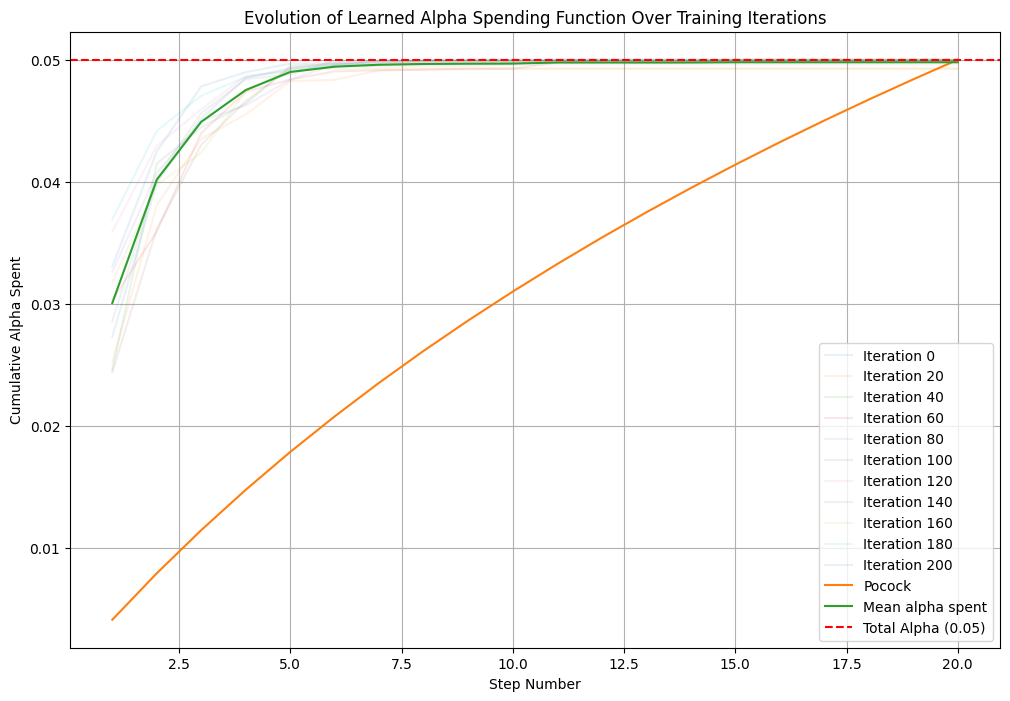

In [55]:
max_steps = DEFAULT_CONFIG['max_looks']

step_numbers = list(range(1, max_steps + 1))
simulation_interval = 20  # This should match the interval used in run_training

plt.figure(figsize=(12, 8))

for i, cumulative_alpha in enumerate(cumulative_alpha_history):
    iteration = i * simulation_interval
    plt.plot(step_numbers, cumulative_alpha, label=f'Iteration {iteration}', alpha=0.1 )

def alpha_star(k, alpha=0.05):
  k=np.array(k)
  k = k/k.max()
  return alpha*np.log(1+(np.e-1)*k)

plt.plot(k, alpha_star(step_numbers), label=f'Pocock' )

plt.plot(step_numbers,np.array(cumulative_alpha_history).mean(axis=0), label=f'Mean alpha spent')

plt.xlabel('Step Number')
plt.ylabel('Cumulative Alpha Spent')
plt.title('Evolution of Learned Alpha Spending Function Over Training Iterations')
plt.axhline(y=DEFAULT_CONFIG['alpha'], color='r', linestyle='--', label=f'Total Alpha ({DEFAULT_CONFIG["alpha"]})')
plt.legend()
plt.grid(True)
plt.show()

So interesting! I was expecting some sort of convergence to Lan & DeMets, but the RL learned policy suggests spending **way** more alpha at the begining of the trial. Both alpha spending strategies keep early significance level high, keeping the trial going to accumulate more data. I wonder which functional form the RL converged to.